# 顧客區格分析 Customer Segmentation Analysis

## 載入套件與讀取資料

### 載入套件

In [1]:
# 載入所需套件

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
'''
圖形中有中文字型的問題
參考
https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/359974/
'''
from matplotlib.font_manager import FontProperties

han_font = FontProperties(fname=r"c:/windows/fonts/msjh.ttc", size=14) # 中文字形

In [3]:
'''
設計圖形呈現的外觀風格
'''
sns.set(style="whitegrid")

### 讀取資料

In [4]:
# 讀入資料檔
df = pd.read_excel('Online Retail.xlsx')

### 資料清理

In [5]:
# 去除CustomerID沒有資料的紀錄
df = df.dropna(subset=['CustomerID'])

In [6]:
from datetime import date

df = df.assign(PurchaseDate=df.InvoiceDate.apply(lambda x: x.date()))

# 取出2010-12-09到2011-12-09一年之間的資料
df = df[df.PurchaseDate>=date(2010, 12, 9)]

In [7]:
#取出購買紀錄(不包含取消紀錄)
df = df[df.Quantity>0] 

### 資料彙整

In [8]:
# 計算發票上物品總價(單價*數量)
df = df.assign(Total=df.UnitPrice*df.Quantity)

## RFM Model (RFM模型)

RFM模型是由喬治·卡利南（George Cullinan）於1961年所提出，他發現資料庫分析中，有三項重要的指標：最近一次消費（Recency）、消費頻率（Frequency）、與消費金額（Monetary），這三項指標的英文字母的分別為R、F、M，所以就稱為「RFM模型」。

Recency (最近一次消費): 同一顧客的發票紀錄中最後的日期。

分析時採用(發票紀錄中最後的日期與2011-12-10之間的天數)。顧客的recency程度比較大，該值將會比較小。

Frequency (消費頻率): 同一顧客一年中的交易。

分析時採用(不同發票紀錄數量的對數值)，顧客的frequency程度較大，即是他們的發票紀錄數量較多。

Monetary (消費金額): 同一顧客一年中的購買總金額。

分析時採用(發票紀錄上物品總價總和的對數值)，顧客的monetary程度較大，表示。

### Recency

In [10]:
# 找出同一位顧客最近一次購買的日期
CustomerData1 = df.groupby(["CustomerID"])[["PurchaseDate"]].max().reset_index()

# 計算最近購買日期與2011-12-10的差
CustomerData1 = CustomerData1.assign(Recency=date(2011,12,10)-CustomerData1.PurchaseDate)

# 將以秒計算的方式轉換為以天計算的方式
CustomerData1.Recency = CustomerData1.Recency.apply(lambda pdate: pdate.days)

In [11]:
# 查看計算果
CustomerData1.head()

,CustomerID,PurchaseDate,Recency
0,12346.0,2011-01-18,326
1,12347.0,2011-12-07,3
2,12348.0,2011-09-25,76
3,12349.0,2011-11-21,19
4,12350.0,2011-02-02,311


In [9]:
'''
將上面的做法，寫成函數的方式
'''
def recency(pdate):
    # 計算最近購買日期與2011-12-10的差(pdate.max()是最近的購買日期)
    dt = date(2011,12,10) - pdate.max()
    # dt.days：轉換為以天計算的方式
    return(dt.days)

CustomerData1 = df.groupby(["CustomerID"]).agg({"PurchaseDate": recency}).reset_index()\
.rename(columns={"PurchaseDate": "Recency"})

In [23]:
# 查看計算果
CustomerData1.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,3
2,12348.0,76
3,12349.0,19
4,12350.0,311


C:\Users\Leo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


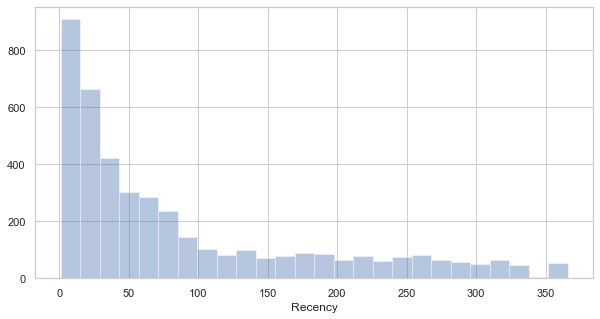

In [24]:
'''
選用直方圖呈現顧客的Recency情形。
'''
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData1.Recency, kde=False)

Text(0.5, 1.0, '顧客的Recency分布情形')

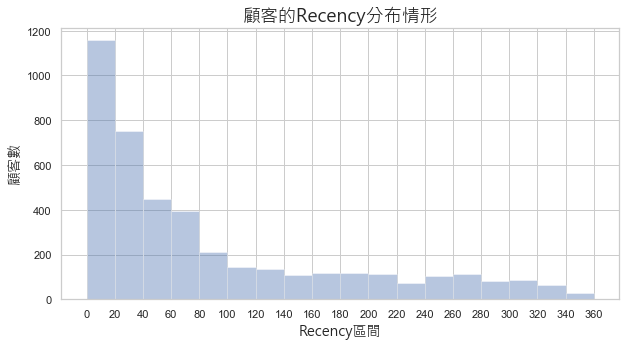

In [26]:
# 將Recency分布的區間設為20，最小值為0，最大值為360

plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData1.Recency, kde=False, bins=np.arange(0, 380, 20))
plt.xticks(np.arange(0, 380, 20)) # x軸上的刻度

ax.set_xlabel("Recency區間", fontproperties=han_font) # x軸的標題，字型選用中文字型
ax.set_ylabel("顧客數", fontproperties=han_font) # y軸的標題
ax.set_title('顧客的Recency分布情形', fontproperties=han_font, fontsize=18)

### Frequency

In [10]:
# 計算每位顧客在一年內有多少次購買紀錄(一次紀錄有一個發票號碼)

CustomerData2 = df.groupby(["CustomerID"])[["InvoiceNo"]].nunique().reset_index()\
.rename(columns={"InvoiceNo": "Frequency"})

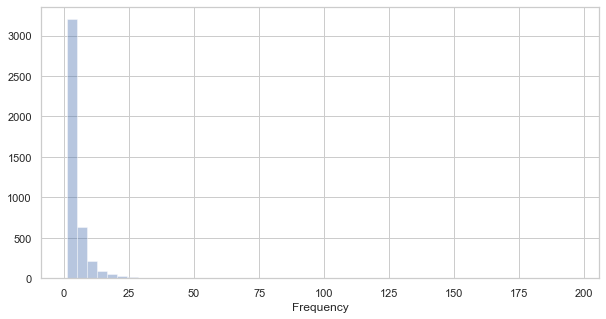

In [28]:
'''
選用直方圖呈現顧客的Frequency情形。
'''
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData2.Frequency, kde=False)

大部分的顧客購買次數相當少，因此設法採用對數，對數是利用numpy的log()方法

In [11]:
CustomerData2.Frequency = np.log(CustomerData2.Frequency)

C:\Users\Leo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


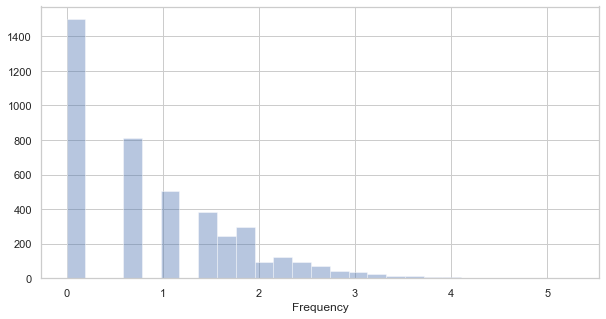

In [12]:
'''
選用直方圖呈現顧客的Frequency情形。
'''
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData2.Frequency, kde=False)

Text(0.5, 1.0, '顧客的Frequency分布情形')

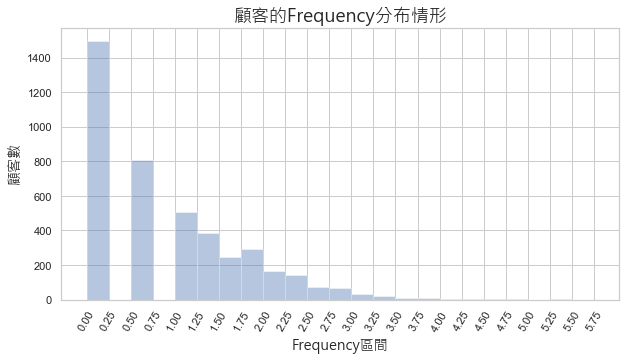

In [13]:
'''
選用直方圖呈現顧客的Frequency情形。
'''
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData2.Frequency, kde=False, bins=np.arange(0, 6, 0.25))
plt.xticks(np.arange(0, 6, 0.25), rotation=60) # x軸上的刻度

ax.set_xlabel("Frequency區間", fontproperties=han_font) # x軸的標題，字型選用中文字型
ax.set_ylabel("顧客數", fontproperties=han_font)
ax.set_title('顧客的Frequency分布情形', fontproperties=han_font, fontsize=18)

In [10]:
'''
將計算Frequency的方式改寫為函數
'''
def frequency(inv):
    return(np.log(inv.nunique()))

CustomerData2 = df.groupby(["CustomerID"]).agg({"InvoiceNo": frequency}).reset_index()\
.rename(columns={"InvoiceNo": "Frequency"})

Text(0.5, 1.0, '顧客的Frequency分布情形')

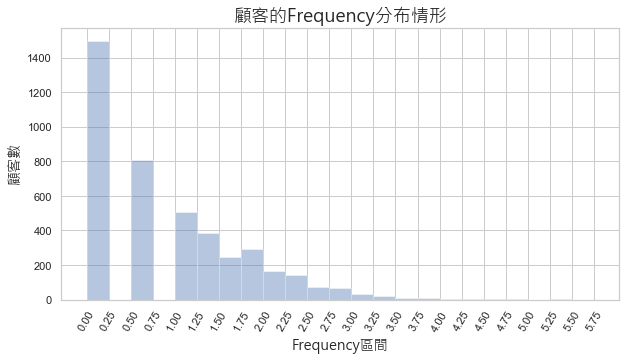

In [33]:
'''
選用直方圖呈現顧客的Frequency情形。
'''
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData2.Frequency, kde=False, bins=np.arange(0, 6, 0.25))
plt.xticks(np.arange(0, 6, 0.25), rotation=60) # x軸上的刻度

ax.set_xlabel("Frequency區間", fontproperties=han_font) # x軸的標題，字型選用中文字型
ax.set_ylabel("顧客數", fontproperties=han_font)
ax.set_title('顧客的Frequency分布情形', fontproperties=han_font, fontsize=18)

### Monetary

In [14]:
# 計算每位顧客在一年內的購買總金額

CustomerData3 = df.groupby(["CustomerID"])[["Total"]].sum().reset_index()\
.rename(columns={"Total": "Monetary"})

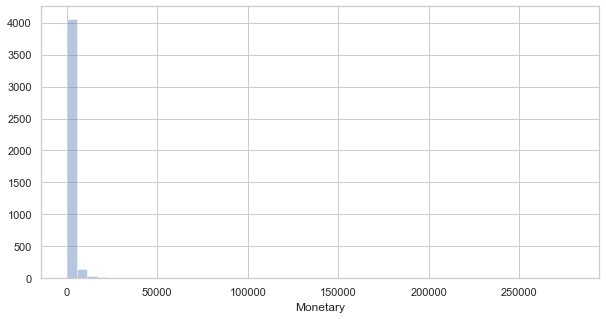

In [35]:
'''
選用直方圖呈現顧客的Monetary情形。
'''
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData3.Monetary, kde=False)

大部分的顧客購買總金額相當少，因此設法採用對數，對數是利用numpy的log10()方法，並且有些顧客的購買金額是0，所以先加上1，避免產生log10(0)為負無限大的情形。

In [15]:
CustomerData3.Monetary = np.log10(CustomerData3.Monetary+1)

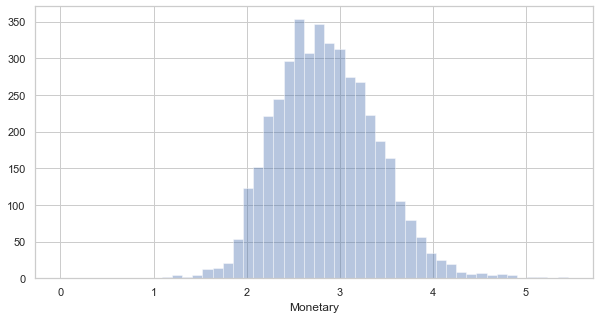

In [16]:
'''
選用直方圖呈現顧客的Monetary情形。
'''
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData3.Monetary, kde=False)

Text(0.5, 1.0, '顧客的Monetary分布情形')

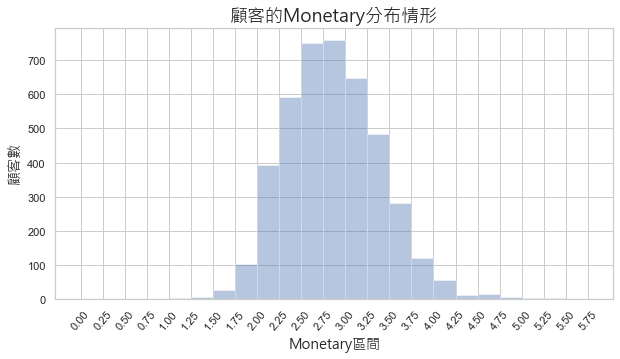

In [17]:
'''
選用直方圖呈現顧客的Monetary情形。
'''
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData3.Monetary, kde=False, bins=np.arange(0, 6, 0.25))
plt.xticks(np.arange(0, 6, 0.25), rotation=50) # x軸上的刻度

ax.set_xlabel("Monetary區間", fontproperties=han_font) # x軸的標題，字型選用中文字型
ax.set_ylabel("顧客數", fontproperties=han_font)
ax.set_title('顧客的Monetary分布情形', fontproperties=han_font, fontsize=18)

In [11]:
'''
將計算Frequency的方式改寫為函數
'''
def monetary(tot):
    return(np.log10(tot.sum()+1))

CustomerData3 = df.groupby(["CustomerID"]).agg({"Total": monetary}).reset_index()\
.rename(columns={"Total": "Monetary"})

Text(0.5, 1.0, '顧客的Monetary分布情形')

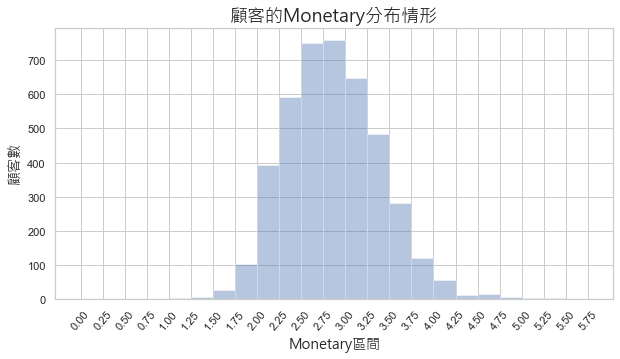

In [19]:
'''
選用直方圖呈現顧客的Monetary情形。
'''
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.distplot(CustomerData3.Monetary, kde=False, bins=np.arange(0, 6, 0.25))
plt.xticks(np.arange(0, 6, 0.25), rotation=50) # x軸上的刻度

ax.set_xlabel("Monetary區間", fontproperties=han_font) # x軸的標題，字型選用中文字型
ax.set_ylabel("顧客數", fontproperties=han_font)
ax.set_title('顧客的Monetary分布情形', fontproperties=han_font, fontsize=18)

In [ ]:
### 將Recency、Frequency和Monetary三者整合

In [12]:
CustomerData = df.groupby(["CustomerID"]).agg({"PurchaseDate": recency,
                                               "InvoiceNo": frequency,
                                               "Total": monetary}).reset_index()\
.rename(columns={"PurchaseDate": "Recency",
                 "InvoiceNo": "Frequency",
                 "Total": "Monetary"})

In [46]:
CustomerData.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,0.000000,4.887531
1,12347.0,3,1.791759,3.556207
2,12348.0,76,1.386294,3.254848
3,12349.0,19,0.000000,3.245155
4,12350.0,311,0.000000,2.525563


### 以圖呈現每一對變數之間的關係

<Figure size 720x360 with 0 Axes>

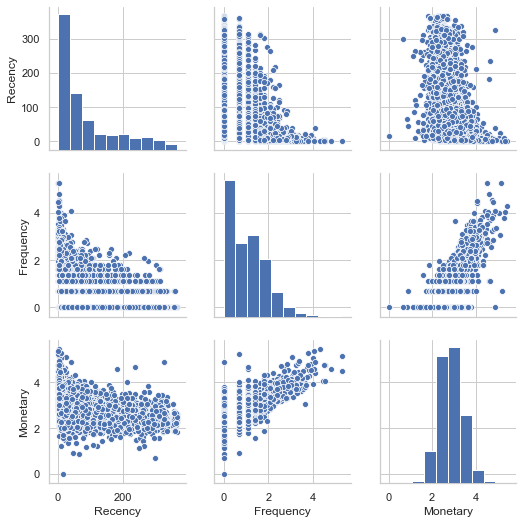

In [26]:
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.pairplot(CustomerData, vars=["Recency", "Frequency", "Monetary"])

## 利用k-means進行Customer Segmentation

什麼是集群？集群就是將所有資料分成幾個群組，使得相似的資料聚集成一個群組，稱為Cluster。

集群有許多演算法，其中 K-means 是其中概念較簡單，容易實作，因此許多資料分析也都採用 K-means。其概念如下：

1. 如果預先決定要分成k個群組，隨機選k個資料做群組的中心。

2. 將每一個資料指派到離自己最近的群組中心。

3. 利用指派到各個群組的資料的平均數，重新計算群組中心。

4. 反覆 2、3 動作，直到群組的成員不變，群組中心不動為止。

運用python進行K-means時，通常使用sklearn套件的KMeans方法。另外通常在進行KMeans之前，會對輸入的資料特徵進行標準化，使標準化後的資料特徵其平均值為0，標準差為1。標準化通常使用sklearn套件的preprocessing方法。

In [13]:
# 從sklearn套件中，載入KMeans方法
from sklearn.preprocessing import StandardScaler
# 從sklearn套件中，載入KMeans方法
from sklearn.cluster import KMeans

In [16]:
X = CustomerData.iloc[:, 1:].values

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [29]:
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(X)

In [30]:
CustomerData = CustomerData.assign(ClusterID=y_km)

In [31]:
CustomerData.head()

,CustomerID,Recency,Frequency,Monetary,ClusterID
0,12346.0,326,0.000000,4.887531,1
1,12347.0,3,1.791759,3.556207,0
2,12348.0,76,1.386294,3.254848,0
3,12349.0,19,0.000000,3.245155,2
4,12350.0,311,0.000000,2.525563,1


C:\Users\Leo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x360 with 0 Axes>

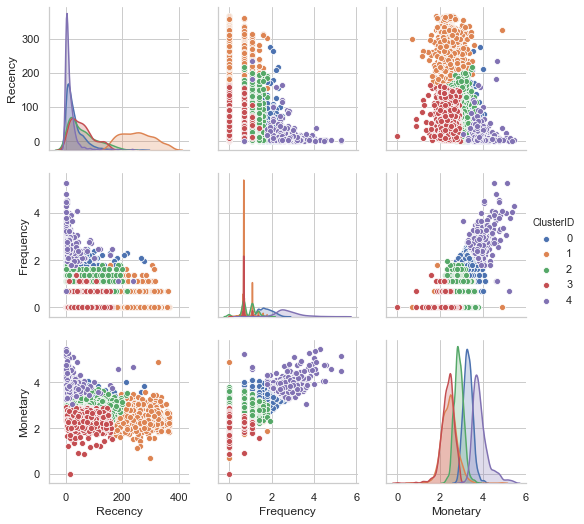

In [32]:
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.pairplot(CustomerData, vars=["Recency", "Frequency", "Monetary"], hue="ClusterID")

In [ ]:
### 多少群族才足夠？

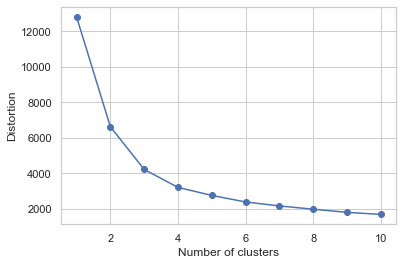

In [33]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [37]:
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(X)

In [38]:
CustomerData = CustomerData.assign(ClusterID=y_km)

C:\Users\Leo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x360 with 0 Axes>

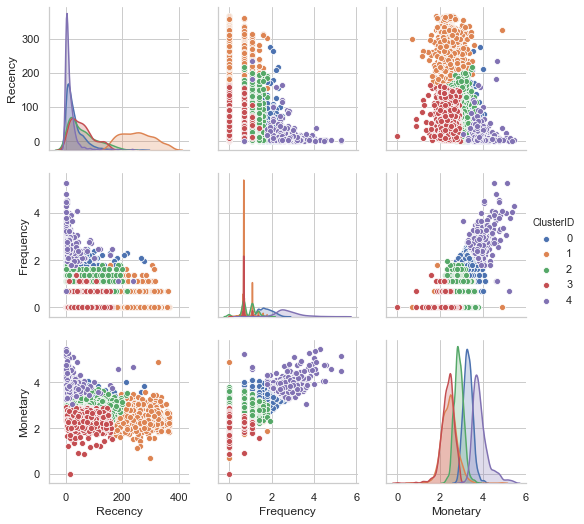

In [40]:
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.pairplot(CustomerData, vars=["Recency", "Frequency", "Monetary"], hue="ClusterID")

In [46]:
CustomerData.groupby(["ClusterID"]).agg({"CustomerID": "count",
                                         "Recency": "median",
                                         "Frequency": "median",
                                         "Monetary": "median"})\
.reset_index()

,ClusterID,CustomerID,Recency,Frequency,Monetary
0,0,953,20,1.791759,3.302119
1,1,871,250,0.000000,2.464430
2,2,1173,47,1.098612,2.872774
3,3,931,51,0.000000,2.397262
4,4,347,9,2.639057,3.794963


In [42]:
cluster4 = CustomerData.CustomerID[CustomerData.ClusterID==4]

In [47]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PurchaseDate,Total
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09,47.4
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09,37.2
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09,15.3
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,31.8
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,15.9
